# Random Forest Implementation

### PreProcess Data

In [69]:
import SL_API as pre
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
imp.reload(pre)
X_test, y_test, X_train_split, y_train_split, X_valid, y_valid, X_train, y_train = pre.PreProcessData()
modelAnalyzer = pre.ModelAnalysis()

### Class Construction

#### Decision Tree

In [70]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))

        # Check termination conditions
        if depth == self.max_depth or num_classes == 1:
            # Instead of returning the most common class, return the class distribution
            class_counts = np.bincount(y, minlength=num_classes)
            class_probabilities = class_counts / len(y)
            return class_probabilities  # Return probabilities instead of a single class

        # Find the best split
        best_split = self._find_best_split(X, y)

        if best_split['impurity'] == 0:
            # If there's no impurity, return the class distribution
            class_counts = np.bincount(y, minlength=num_classes)
            class_probabilities = class_counts / len(y)
            return class_probabilities

        left_indices = X[:, best_split['feature_index']] <= best_split['threshold']
        right_indices = ~left_indices

        # Recursively build the left and right subtrees
        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {'feature_index': best_split['feature_index'],
                'threshold': best_split['threshold'],
                'left': left_subtree,
                'right': right_subtree}

    def _calculate_gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        gini = 1 - np.sum(probabilities ** 2)
        return gini

    def _find_best_split(self, X, y):
        num_samples, num_features = X.shape
        best_split = {'impurity': None}
        best_gini = float('inf')

        for feature_index in range(num_features):
            thresholds = np.unique(X[:, feature_index])

            for threshold in thresholds:
                left_indices = X[:, feature_index] <= threshold
                right_indices = ~left_indices

                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                left_gini = self._calculate_gini(y[left_indices])
                right_gini = self._calculate_gini(y[right_indices])

                gini = (len(y[left_indices]) / num_samples) * left_gini \
                       + (len(y[right_indices]) / num_samples) * right_gini

                if gini < best_gini:
                    best_split = {'feature_index': feature_index,
                                  'threshold': threshold,
                                  'impurity': gini}
                    best_gini = gini

        return best_split


    def predict(self, X):
        classPredictions = [self._traverse_tree(x, self.tree) for x in X]
        predictions = []
        for pred in classPredictions:
            predictions.append(1-pred[0])
        return predictions

    def _traverse_tree(self, x, node):
        if isinstance(node, np.ndarray):  # If it's a probability distribution
            return node  # Return the class probabilities

        if isinstance(node, dict):
            if x[node['feature_index']] <= node['threshold']:
                return self._traverse_tree(x, node['left'])
            else:
                return self._traverse_tree(x, node['right'])
        else:
            raise ValueError("Invalid node structure")

#### Random Forest

In [71]:
class RandomForest:
    def __init__(self, n_estimators=10, max_depth=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.estimators = []

    def fit(self, X, y):
        self.estimators = []
        for _ in range(self.n_estimators):
            # Create a decision tree
            tree = DecisionTree(max_depth=self.max_depth)
            
            # Randomly sample the data with replacement
            sample_indices = np.random.choice(len(X), size=len(X), replace=True)
            X_sampled = X[sample_indices]
            y_sampled = y[sample_indices]
            
            # Fit the decision tree on the sampled data
            tree.fit(X_sampled, y_sampled)
            
            # Append the decision tree to the list of estimators
            self.estimators.append(tree)

    def predict(self, X):
        # Make predictions using each decision tree and take the majority vote
        predictions = np.array([tree.predict(X) for tree in self.estimators])
        return np.mean(predictions, axis=0)  # Proportion of positives

### Forest with 3 Trees Depth 2

Accuracy: 0.6715916722632639
F1 Score: 0.7792325056433408
Precision: 0.6843774781919112
NPV: 0.6008771929824561
Recall: 0.9046121593291404
Specificity: 0.2560747663551402


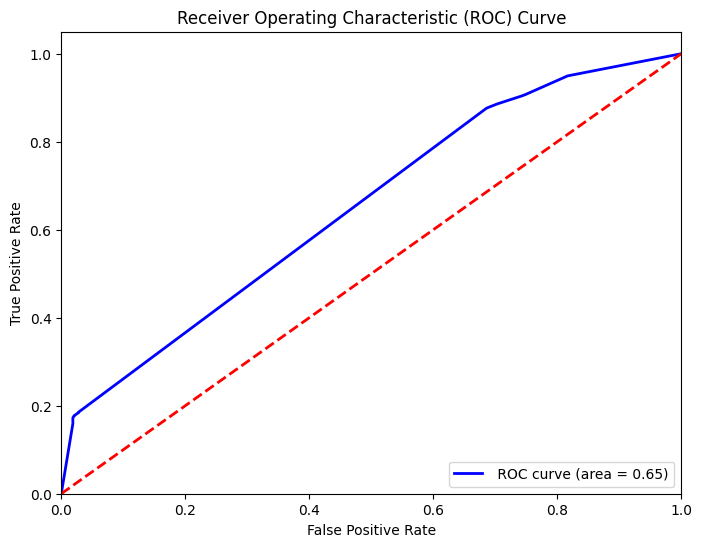

In [77]:
forest2 = RandomForest(n_estimators=3, max_depth=2)
forest2.fit(np.array(X_train), np.array(y_train))
predictions2 = forest2.predict(np.array(X_valid))
modelAnalyzer.printPrediction(predictions2, y_valid)
modelAnalyzer.plot_roc_auc(predictions2, y_valid)

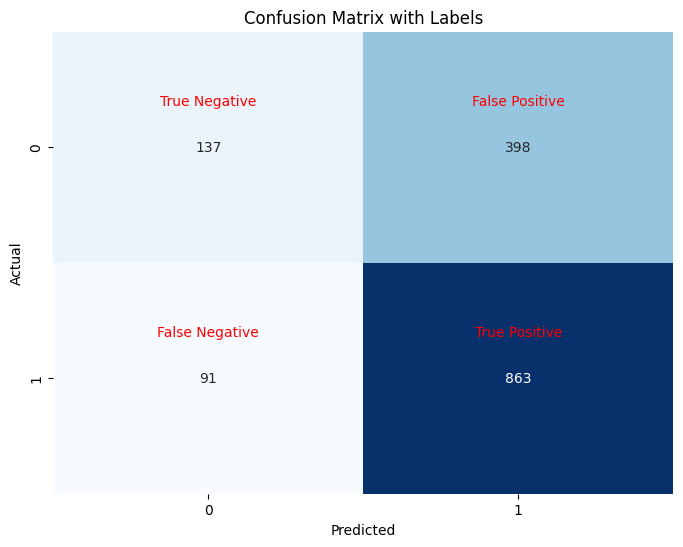

In [78]:
modelAnalyzer.plot(predictions2, y_valid)

### Forest with 3 Trees Depth 3

Accuracy: 0.6863666890530558
F1 Score: 0.790676826535186
Precision: 0.6906812842599843
NPV: 0.660377358490566
Recall: 0.9245283018867925
Specificity: 0.2616822429906542


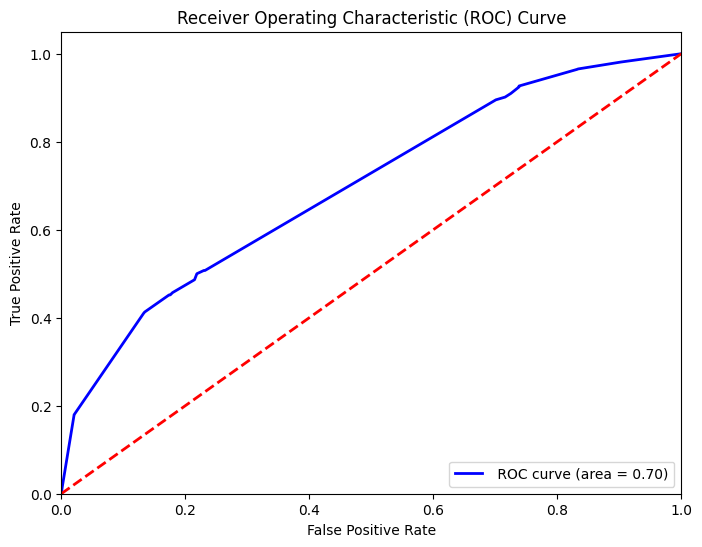

In [79]:
forest3 = RandomForest(n_estimators=3, max_depth=3)
forest3.fit(np.array(X_train), np.array(y_train))
predictions3 = forest3.predict(np.array(X_valid))
modelAnalyzer.printPrediction(predictions3, y_valid)
modelAnalyzer.plot_roc_auc(predictions3, y_valid)

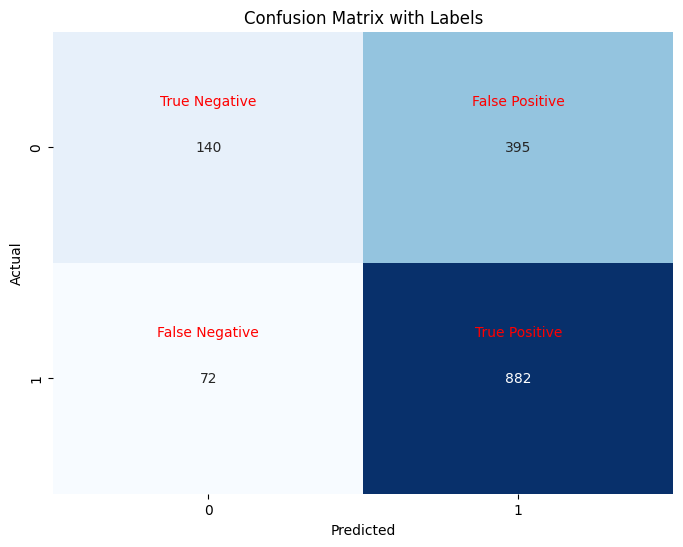

In [80]:
modelAnalyzer.plot(predictions3, y_valid)

### Forest with 3 Trees Depth 8

Accuracy: 0.7293485560779046
F1 Score: 0.8017707820954254
Precision: 0.7553290083410565
NPV: 0.6609756097560976
Recall: 0.8542976939203354
Specificity: 0.5065420560747663


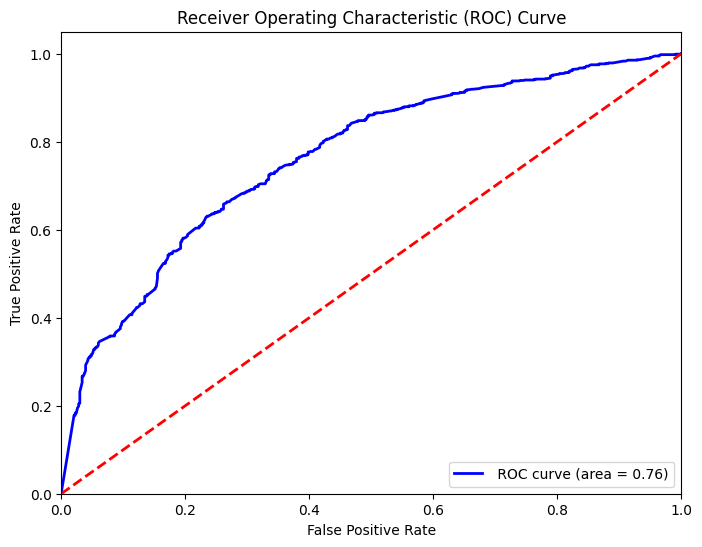

In [82]:
forest8 = RandomForest(n_estimators=3, max_depth=8)
forest8.fit(np.array(X_train), np.array(y_train))
predictions8 = forest8.predict(np.array(X_valid))
modelAnalyzer.printPrediction(predictions8, y_valid)
modelAnalyzer.plot_roc_auc(predictions8, y_valid)

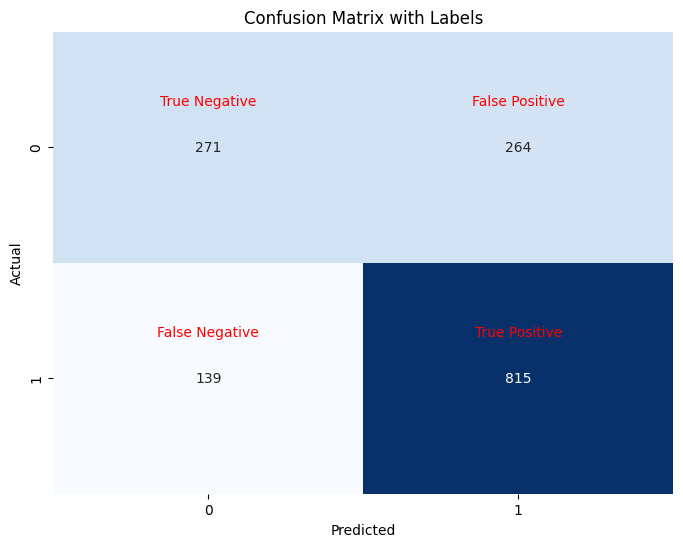

In [83]:
modelAnalyzer.plot(predictions8, y_valid)

### Forest with 5 Trees Depth 8

Accuracy: 0.7293485560779046
F1 Score: 0.8029339853300733
Precision: 0.7525206232813932
NPV: 0.6658291457286433
Recall: 0.860587002096436
Specificity: 0.4953271028037383


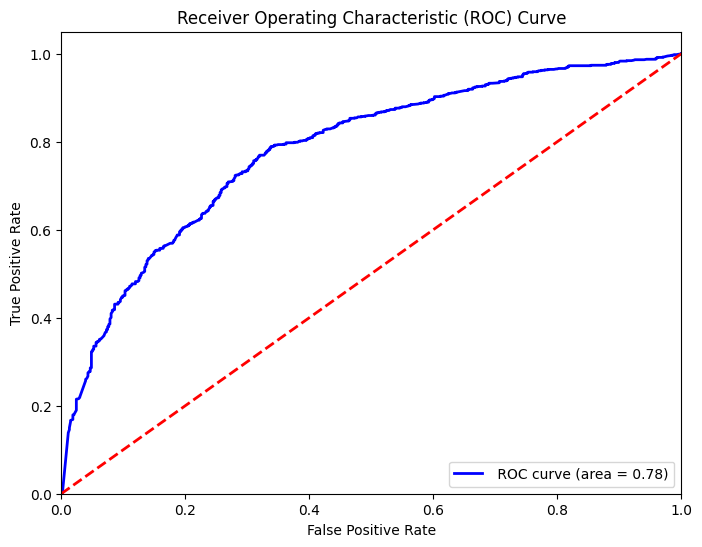

In [85]:
forest58 = RandomForest(n_estimators=5, max_depth=8)
forest58.fit(np.array(X_train), np.array(y_train))
predictions58 = forest58.predict(np.array(X_valid))
modelAnalyzer.printPrediction(predictions58, y_valid)
modelAnalyzer.plot_roc_auc(predictions58, y_valid)

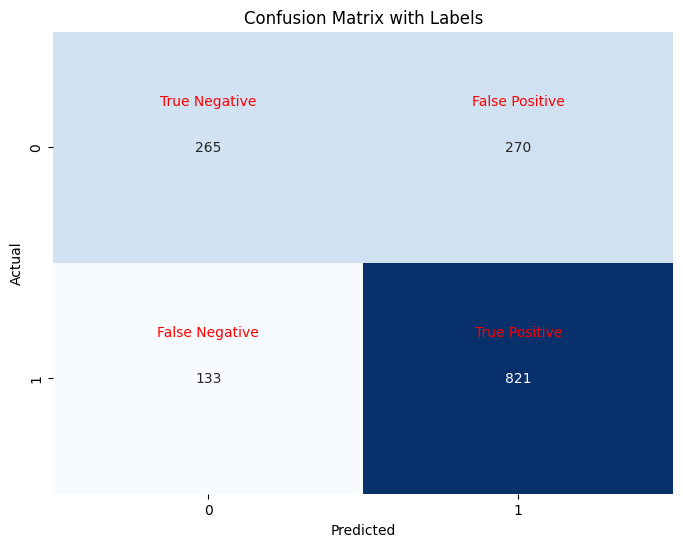

In [86]:
modelAnalyzer.plot(predictions58, y_valid)

### Forest with 7 Trees Depth 8

Accuracy: 0.7280053727333781
F1 Score: 0.8027277155382366
Precision: 0.7497725204731575
NPV: 0.6666666666666666
Recall: 0.8637316561844863
Specificity: 0.48598130841121495


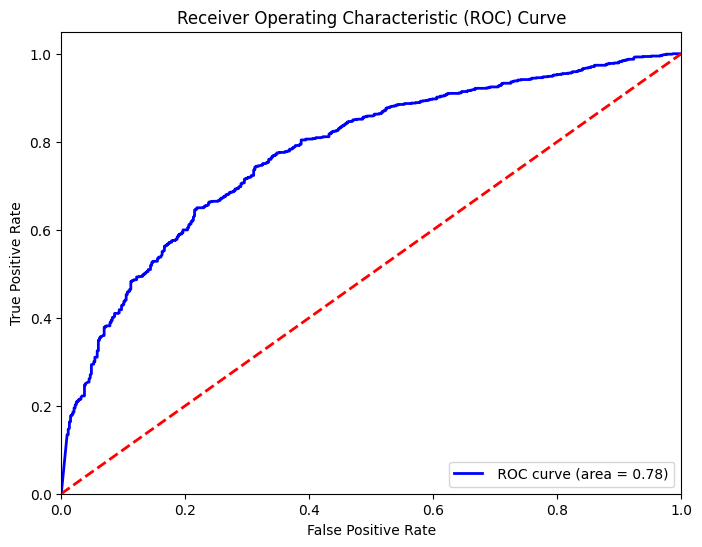

In [87]:
forest78 = RandomForest(n_estimators=7, max_depth=8)
forest78.fit(np.array(X_train), np.array(y_train))
predictions78 = forest78.predict(np.array(X_valid))
modelAnalyzer.printPrediction(predictions78, y_valid)
modelAnalyzer.plot_roc_auc(predictions78, y_valid)

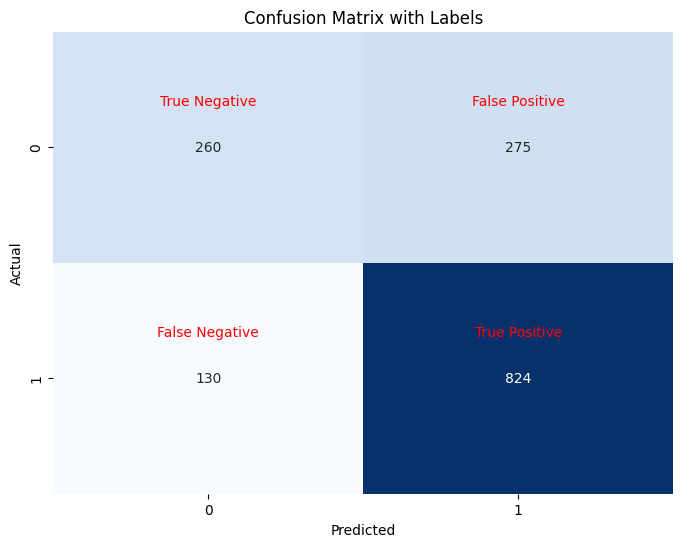

In [88]:
modelAnalyzer.plot(predictions78, y_valid)

### Forest with 9 Trees Depth 8

Accuracy: 0.738079247817327
F1 Score: 0.8112294288480155
Precision: 0.7535971223021583
NPV: 0.6923076923076923
Recall: 0.8784067085953878
Specificity: 0.48785046728971965


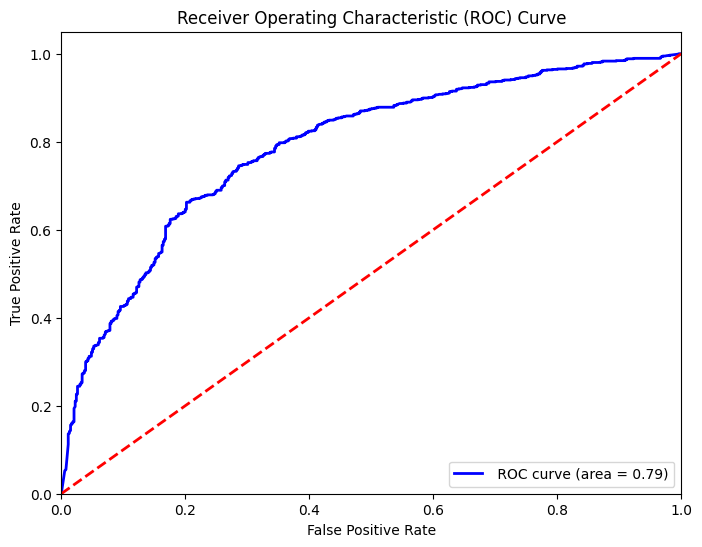

In [90]:
forest98 = RandomForest(n_estimators=9, max_depth=8)
forest98.fit(np.array(X_train), np.array(y_train))
predictions98 = forest98.predict(np.array(X_valid))
modelAnalyzer.printPrediction(predictions98, y_valid)
modelAnalyzer.plot_roc_auc(predictions98, y_valid)

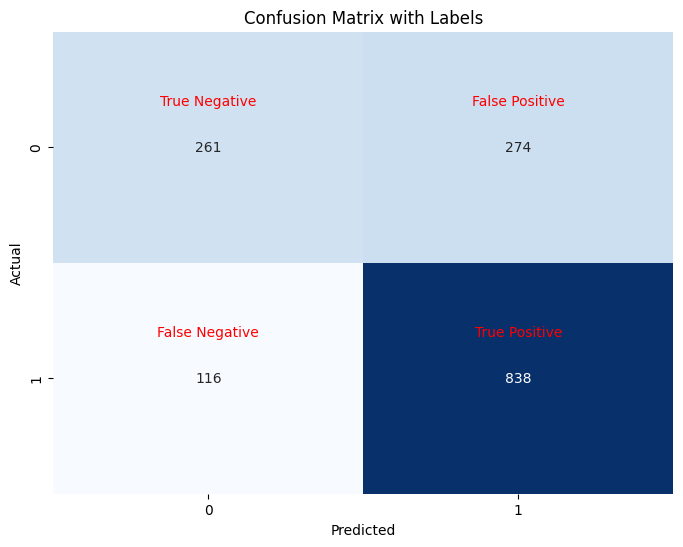

In [91]:
modelAnalyzer.plot(predictions98, y_valid)

### Forest with 11 Trees Depth 8

Accuracy: 0.7239758226997985
F1 Score: 0.7998051631758403
Precision: 0.7470427661510464
NPV: 0.658974358974359
Recall: 0.860587002096436
Specificity: 0.4803738317757009


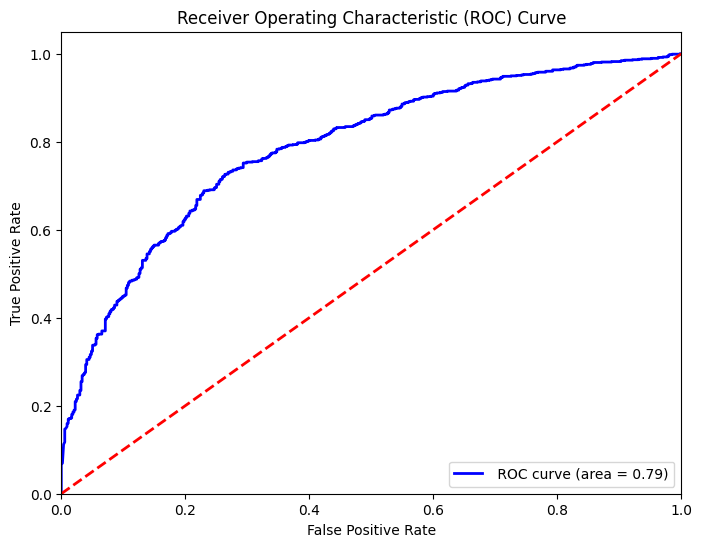

In [95]:
forest118 = RandomForest(n_estimators=11, max_depth=8)
forest118.fit(np.array(X_train), np.array(y_train))
predictions118 = forest118.predict(np.array(X_valid))
modelAnalyzer.printPrediction(predictions118, y_valid)
modelAnalyzer.plot_roc_auc(predictions118, y_valid)

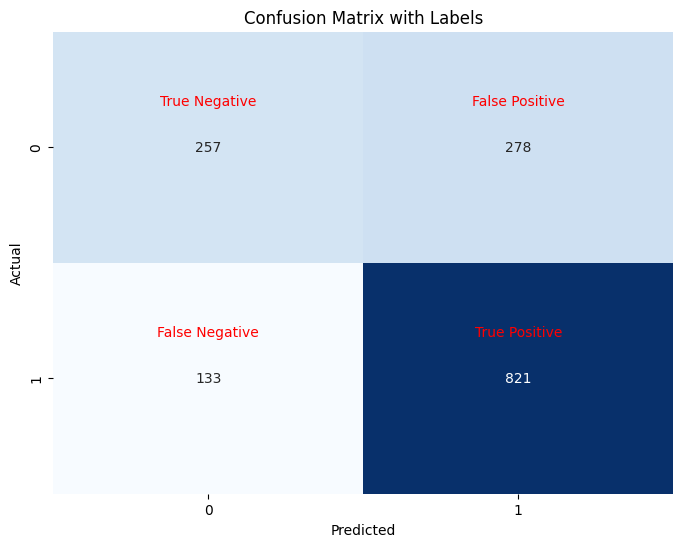

In [96]:
modelAnalyzer.plot(predictions118, y_valid)

### Forest with 10 Trees Depth 8

Accuracy: 0.7353928811282741
F1 Score: 0.8068627450980392
Precision: 0.7578268876611418
NPV: 0.674937965260546
Recall: 0.8626834381551363
Specificity: 0.508411214953271


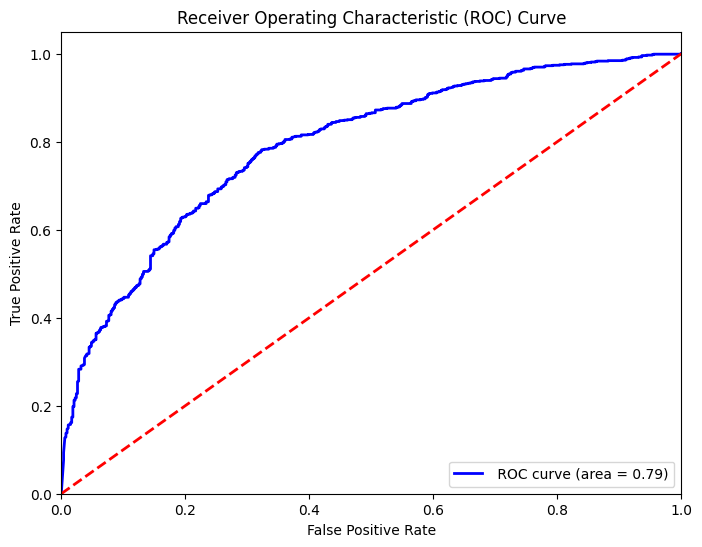

In [97]:
forest108 = RandomForest(n_estimators=10, max_depth=8)
forest108.fit(np.array(X_train), np.array(y_train))
predictions108 = forest108.predict(np.array(X_valid))
modelAnalyzer.printPrediction(predictions108, y_valid)
modelAnalyzer.plot_roc_auc(predictions108, y_valid)

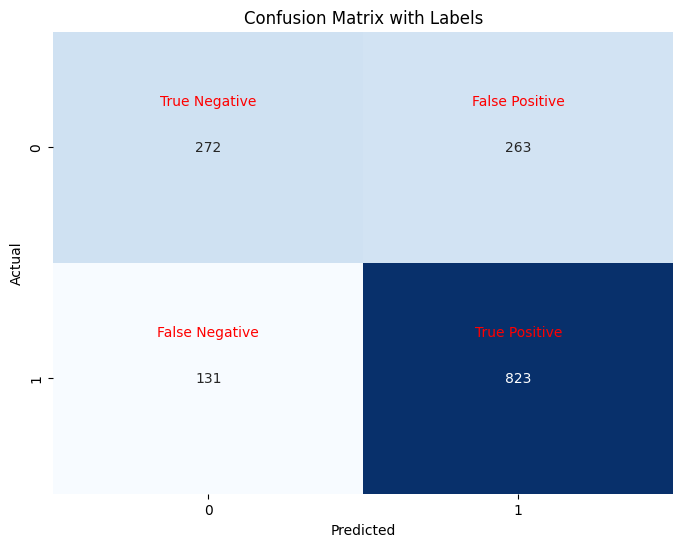

In [98]:
modelAnalyzer.plot(predictions108, y_valid)

### Forest with 8 Trees Depth 8

Accuracy: 0.7199462726662189
F1 Score: 0.797277588721439
Precision: 0.743427017225748
NPV: 0.6528497409326425
Recall: 0.859538784067086
Specificity: 0.47102803738317756


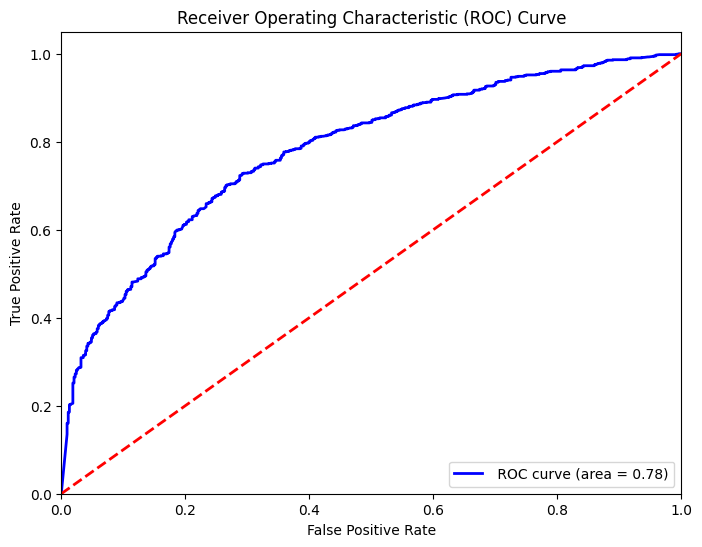

In [99]:
forest88 = RandomForest(n_estimators=8, max_depth=8)
forest88.fit(np.array(X_train), np.array(y_train))
predictions88 = forest88.predict(np.array(X_valid))
modelAnalyzer.printPrediction(predictions88, y_valid)
modelAnalyzer.plot_roc_auc(predictions88, y_valid)

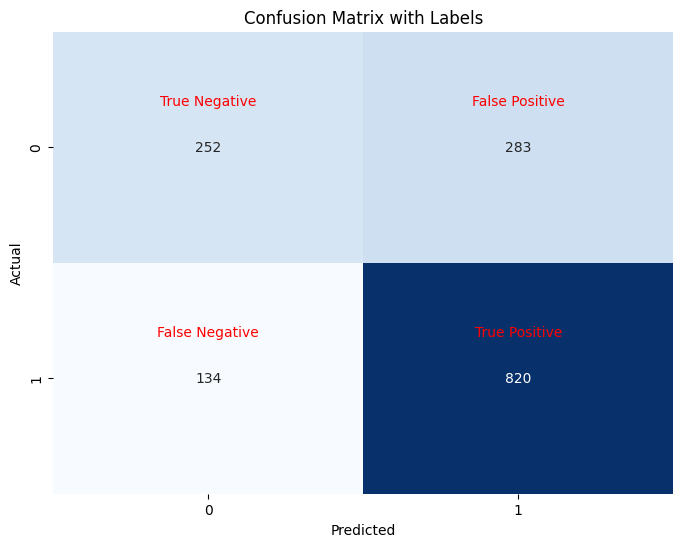

In [100]:
modelAnalyzer.plot(predictions88, y_valid)

### Make the best Model have a Higher (recall/specificity ratio) with Youden index

In [101]:
best_threshold = modelAnalyzer.youdenIndex(predictions98, y_valid)
modelAnalyzer.printPrediction(predictions98, y_valid, threshold=best_threshold)

Model Logistic Regression: Best Threshold = 0.659, Youden Index = 0.461
Accuracy: 0.7112155809267965
F1 Score: 0.7461629279811098
Precision: 0.8540540540540541
NPV: 0.5700934579439252
Recall: 0.6624737945492662
Specificity: 0.7981308411214953


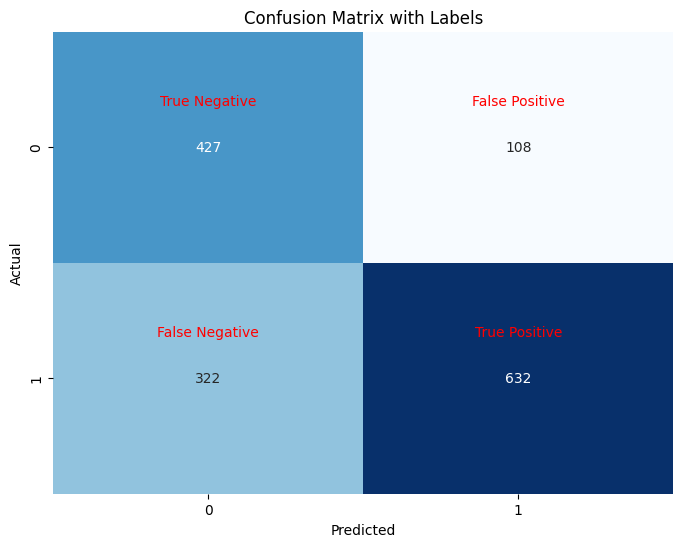

In [102]:
modelAnalyzer.plot(predictions98, y_valid, threshold=best_threshold)

### Test Model on Test Data

Accuracy: 0.7320349227669577
F1 Score: 0.8031573754316724
Precision: 0.7572093023255814
NPV: 0.6666666666666666
Recall: 0.8550420168067226
Specificity: 0.5139664804469274


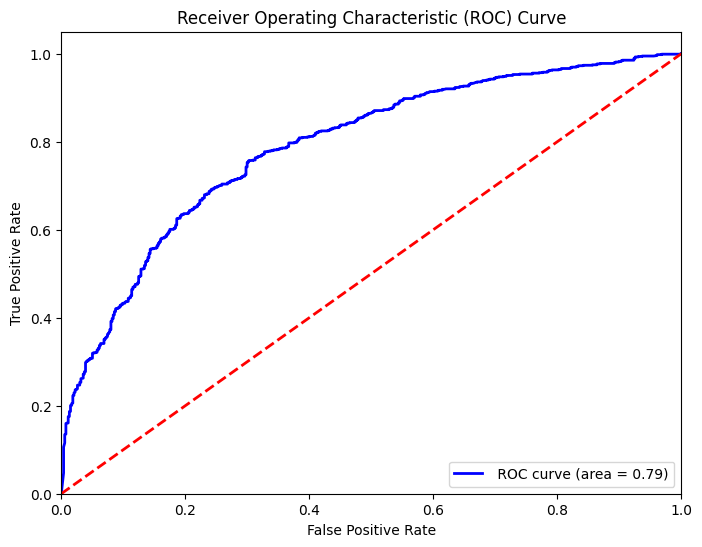

In [104]:
forest98Test = RandomForest(n_estimators=9, max_depth=8)
forest98Test.fit(np.array(X_train_split), np.array(y_train_split))
predictions98Test = forest98Test.predict(np.array(X_test))
modelAnalyzer.printPrediction(predictions98Test, y_test)
modelAnalyzer.plot_roc_auc(predictions98Test, y_test)

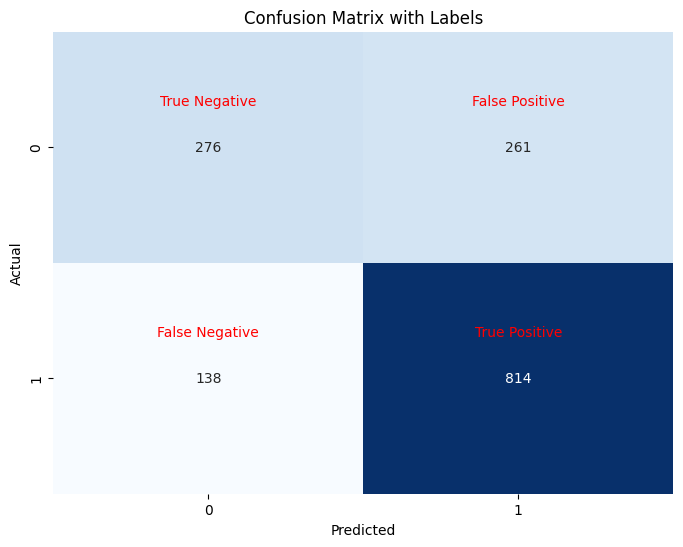

In [105]:
modelAnalyzer.plot(predictions98Test, y_test)